In [1]:
from collections import defaultdict
import itertools
import os
from pathlib import Path
import random
import time

import IPython.display

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
import math

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 39s 0us/step


In [9]:
print(X_train.shape, y_train.shape)
print(tf.reduce_min(X_train))
print(tf.reduce_max(X_train))
print(tf.reduce_min(y_train))
print(tf.reduce_max(y_train))

(50000, 32, 32, 3) (50000, 1)
tf.Tensor(0, shape=(), dtype=uint8)
tf.Tensor(255, shape=(), dtype=uint8)
tf.Tensor(0, shape=(), dtype=uint8)
tf.Tensor(9, shape=(), dtype=uint8)


In [10]:
X_train = X_train / 255.
X_test = X_test / 255.

In [29]:
X_val = X_train[-10000:]
X_train = X_train[:-10000]

In [3]:
def base_log_dir():
    return os.path.join(os.curdir, ".tflogs", "reber_grammar")

def get_tensorboard_cb(callback=keras.callbacks.TensorBoard):
    base_dir = base_log_dir()
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S")
    run_dir = os.path.join(base_dir, run_id)
    return callback(run_dir)

In [105]:
def build_model(optimizer=keras.optimizers.Adam, learning_rate=1e-3):
    encoder = keras.models.Sequential([
        keras.layers.GaussianNoise(.1, seed=42, input_shape=[32, 32, 3]),
        keras.layers.Conv2D(16, kernel_size=3, padding="same", activation="selu"),
        keras.layers.MaxPool2D(pool_size=2),
        keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="selu"),
        keras.layers.MaxPool2D(pool_size=2),
        keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="selu"),
        keras.layers.MaxPool2D(pool_size=2),
    ])
    
    decoder = keras.models.Sequential([
        keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", activation="selu", input_shape=[4, 4, 64]),
        keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="same", activation="selu"),
        keras.layers.Conv2DTranspose(3, kernel_size=3, strides=2, padding="same", activation="sigmoid"),
    ])
    
    autoencoder = keras.models.Sequential([encoder, decoder])
    
    
    autoencoder.compile(
        loss="mse",
        optimizer=optimizer(learning_rate=learning_rate),
    )
    
    return autoencoder

In [26]:
class LearningRateCallback(keras.callbacks.Callback):
    def __init__(self, initial_learning_rate, final_learning_rate, steps):
        self.factor = math.exp(math.log(final_learning_rate/float(initial_learning_rate))/steps)
        self.losses = []
        self.learning_rates = []
    
    def on_batch_end(self, batch, logs):
        self.losses.append(logs.get("loss"))
        learning_rate = keras.backend.get_value(self.model.optimizer.learning_rate)
        self.learning_rates.append(learning_rate)
        keras.backend.set_value(self.model.optimizer.learning_rate, learning_rate*self.factor)

def find_best_learning_rate(
    X_train,
    compiled_model, 
    n_steps=500,
    learning_rate_min=1e-5, 
    learning_rate_max=1e-1,
    ):
    keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)  
    
    learning_rate_callback = LearningRateCallback(learning_rate_min, learning_rate_max, n_steps)
    
    history = compiled_model.fit(
      X_train,
      X_train,
      epochs=1,
      steps_per_epoch=n_steps,
      callbacks=[learning_rate_callback],
    )
    
    
    learning_rates = np.array(learning_rate_callback.learning_rates)
    losses = np.array(learning_rate_callback.losses)
    idx = losses < 10000
    learning_rates_clean = learning_rates[idx]
    losses_clean = losses[idx]
    
    plt.plot(learning_rates_clean, losses_clean)
    best_idx = np.argmin(losses_clean)
    best_learning_rate = learning_rates[best_idx] / 10.
    return best_learning_rate

In [80]:
def train_model(
    X_train,
    X_val,
    compiled_model, 
    callbacks=None,
    n_epochs=500,
    steps_per_epoch=None,
    tensorboard_callback=keras.callbacks.TensorBoard,
    ):
    callbacks = callbacks or []
    keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)
    
    builtin_callbacks = [
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        get_tensorboard_cb(callback=tensorboard_callback),
    ]
    
    history = compiled_model.fit(
        X_train,
        X_train,
        epochs=n_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=(X_val, X_val),
        callbacks=callbacks + builtin_callbacks,
    )

500/500 [==============================] - 5s 9ms/step - loss: 0.0603


0.0015488152392208576

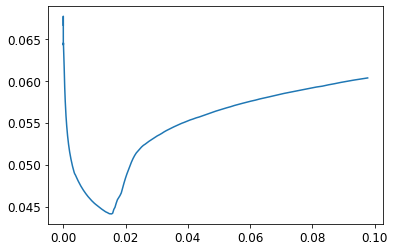

In [106]:
model = build_model(learning_rate=1e-6)
best_learning_rate = find_best_learning_rate(X_train, model, learning_rate_min=1e-6, learning_rate_max=1e-1)
best_learning_rate

In [58]:
print(32*32*3, 4*4*64)

3072 1024


In [107]:
model = build_model(learning_rate=best_learning_rate)
train_model(X_train, X_val, model)

Epoch 1/500
1250/1250 [==============================] - 11s 9ms/step - loss: 0.0107 - val_loss: 0.0080
Epoch 2/500
1250/1250 [==============================] - 10s 8ms/step - loss: 0.0070 - val_loss: 0.0064
Epoch 3/500
1250/1250 [==============================] - 10s 8ms/step - loss: 0.0064 - val_loss: 0.0060
Epoch 4/500
1250/1250 [==============================] - 10s 8ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 5/500
1250/1250 [==============================] - 10s 8ms/step - loss: 0.0058 - val_loss: 0.0053
Epoch 6/500
1250/1250 [==============================] - 10s 8ms/step - loss: 0.0057 - val_loss: 0.0052
Epoch 7/500
1250/1250 [==============================] - 10s 8ms/step - loss: 0.0056 - val_loss: 0.0050
Epoch 8/500
1250/1250 [==============================] - 10s 8ms/step - loss: 0.0054 - val_loss: 0.0050
Epoch 9/500
1250/1250 [==============================] - 10s 8ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 10/500
1250/1250 [==============================] - 10s 8m

In [99]:
n = 100
idx = np.random.choice(X_train.shape[0], n, replace=False)
X_sample = X_train[idx]

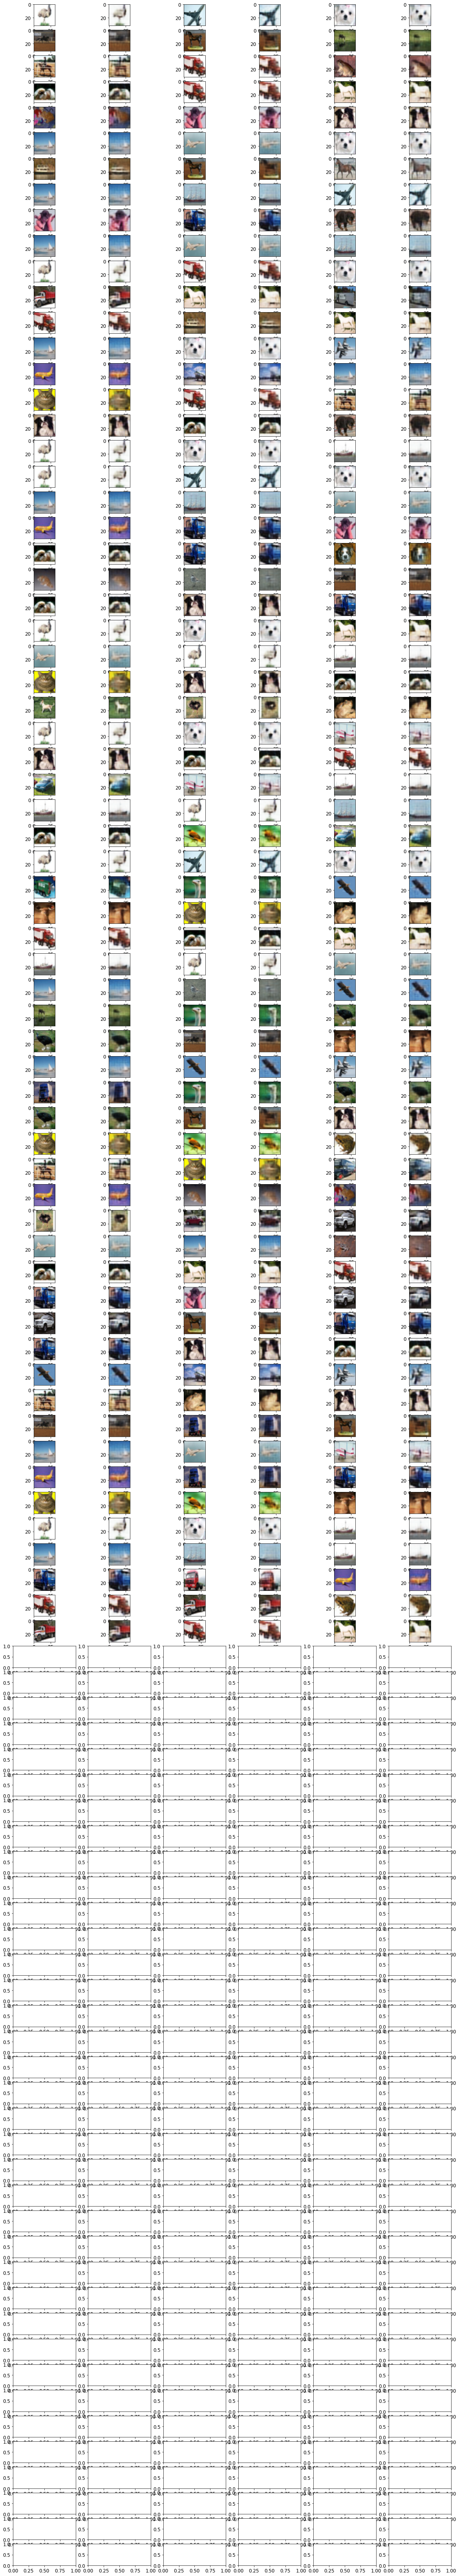

In [108]:
k = 3
fig, axs = plt.subplots(n, 2*k, figsize=(20, 120))

codings = model.layers[0](X_sample)
reconstructions = model.layers[1](codings).numpy()

fmap_activations = tf.reduce_sum(codings, axis=[1, 2])

top_activations, top_indices = tf.math.top_k(tf.transpose(fmap_activations), k=3)

# for i, sample in enumerate(X_sample):
#     axs[i, 0].imshow(sample)
#     axs[i, 1].imshow(reconstructions[i])
#     
#     # print(f"sample {i} {sample.shape}:\n{sample}")
#     # print(f"reconstruction {i} {reconstruction.shape}:\n {reconstruction}")

for i, row in enumerate(top_indices.numpy()):
    imgs = X_sample[row]
    recs = reconstructions[row]
    for j in range(k):
        axs[i, j*2].imshow(imgs[j])
        axs[i, j*2+1].imshow(recs[j])

[<KerasTensor: shape=(None, 4, 4, 64) dtype=float32 (created by layer 'max_pooling2d_2')>]
[<KerasTensor: shape=(None, 32, 32, 3) dtype=float32 (created by layer 'conv2d_transpose_2')>]
